In [1]:
# imports
import matplotlib.pyplot as plt
import matplotlib
# import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
import math
import sys
sys.path.append('../')

#import pretrainedmodels
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from gated import *
from resnet import resnet18
from resnet_gated import resnet18_gated
from train import train_sgd, test, train_gated
from dataset import *

[0.05, 0.04351133533380851, 0.03763019350290237, 0.03233860639039575, 0.027610188407766852, 0.023412708106044778, 0.019710173577058045, 0.01646450246756338, 0.013636839516207507, 0.011188577139226377, 0.00908212776868068, 0.0072814904000044894, 0.005752648131336976, 0.004463828361377955, 0.003385652732557608, 0.0024911998332304472, 0.0017560000734507363, 0.001157978988356383, 0.0006773624649329806, 0.00029655499559261365]


In [2]:
# !pip install pretrainedmodels

In [3]:
# device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float
BATCH_SIZE = 64

In [4]:
image_paths = list(paths.list_images('../data/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


In [5]:
len(set(labels))

101

In [6]:
# one hot encode
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")


Total number of classes: 101


In [7]:
# divide the data into train, validation, and test set
(x_train, x_val , y_train, y_val) = train_test_split(data, labels, 
                                                    test_size=0.3,  
                                                    stratify=labels,
                                                    random_state=42)

(x_val, x_test, y_val, y_test) = train_test_split(x_val, y_val, 
                                                    test_size=0.65, 
                                                    random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (6073,)
x_test examples: (1693,)
x_val examples: (911,)


In [8]:
np.argmax(y_val[:20], axis=-1)

array([98,  3, 65, 52,  0,  1, 71, 72,  3,  3, 23,  3,  1, 55,  1, 11, 17,
       40, 90, 53])

In [9]:
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

# dataloaders
trainloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
model = resnet18(pretrained=False).to(device)
model_gated = resnet18_gated(pretrained=False).to(device)

dilation [False, False, False]
stride 1
downsample
stride 2
downsample
stride 2
downsample
stride 2
dilation [False, False, False]
stride 1
downsample
stride 2
downsample
stride 2
downsample
stride 2


Training on 6073 examples, validating on 911 examples...
Epoch 1 of 20
Train Loss: 0.0602, Train Acc: 20.81
Val Loss: 0.0557, Val Acc: 28.54
Epoch 2 of 20
Train Loss: 0.0493, Train Acc: 30.48
Val Loss: 0.0506, Val Acc: 31.39
Epoch 3 of 20
Train Loss: 0.0420, Train Acc: 39.42
Val Loss: 0.0406, Val Acc: 43.69
Epoch 4 of 20
Train Loss: 0.0355, Train Acc: 45.88
Val Loss: 0.0384, Val Acc: 45.99
Epoch 5 of 20
Train Loss: 0.0300, Train Acc: 53.15
Val Loss: 0.0367, Val Acc: 48.41
Epoch 6 of 20
Train Loss: 0.0237, Train Acc: 61.58
Val Loss: 0.0307, Val Acc: 55.76
Epoch 7 of 20
Train Loss: 0.0186, Train Acc: 68.10
Val Loss: 0.0273, Val Acc: 58.29
Epoch 8 of 20
Train Loss: 0.0135, Train Acc: 76.40
Val Loss: 0.0282, Val Acc: 60.48
Epoch 9 of 20
Train Loss: 0.0099, Train Acc: 82.18
Val Loss: 0.0233, Val Acc: 64.87
Epoch 10 of 20
Train Loss: 0.0063, Train Acc: 88.46
Val Loss: 0.0227, Val Acc: 66.85
Epoch 11 of 20
Train Loss: 0.0021, Train Acc: 97.13
Val Loss: 0.0177, Val Acc: 73.66
Epoch 12 of 20
Tr

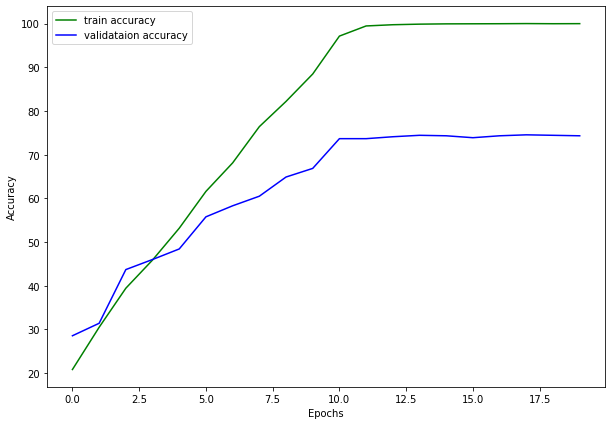

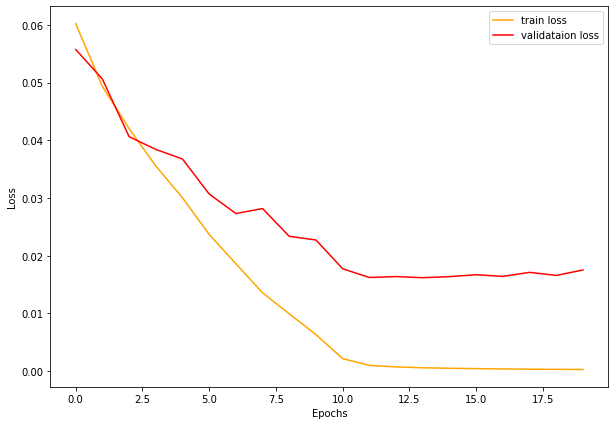

In [11]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
train_sgd(model, trainloader, valloader, decay=0)

In [12]:
correct, total = test(model, testloader)
print('Accuracy of testthe network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

Accuracy of testthe network on test images: 74.070 %
train.py finished running


Training on 6073 examples, validating on 911 examples...
Epoch 1 of 20
Train Loss: 0.0714, Train Acc: 16.27
Val Loss: 0.0732, Val Acc: 16.90
Epoch 2 of 20
Train Loss: 0.0527, Train Acc: 27.91
Val Loss: 0.0538, Val Acc: 30.19
Epoch 3 of 20
Train Loss: 0.0464, Train Acc: 35.01
Val Loss: 0.0511, Val Acc: 36.11
Epoch 4 of 20
Train Loss: 0.0418, Train Acc: 39.44
Val Loss: 0.0454, Val Acc: 41.05
Epoch 5 of 20
Train Loss: 0.0379, Train Acc: 44.00
Val Loss: 0.0405, Val Acc: 45.01
Epoch 6 of 20
Train Loss: 0.0340, Train Acc: 48.79
Val Loss: 0.0399, Val Acc: 46.21
Epoch 7 of 20
Train Loss: 0.0312, Train Acc: 51.69
Val Loss: 0.0346, Val Acc: 50.82
Epoch 8 of 20
Train Loss: 0.0268, Train Acc: 58.01
Val Loss: 0.0364, Val Acc: 50.93
Epoch 9 of 20
Train Loss: 0.0232, Train Acc: 63.38
Val Loss: 0.0336, Val Acc: 52.25
Epoch 10 of 20
Train Loss: 0.0191, Train Acc: 68.22
Val Loss: 0.0301, Val Acc: 57.08
Epoch 11 of 20
Train Loss: 0.0115, Train Acc: 82.07
Val Loss: 0.0256, Val Acc: 60.81
Epoch 12 of 20
Tr

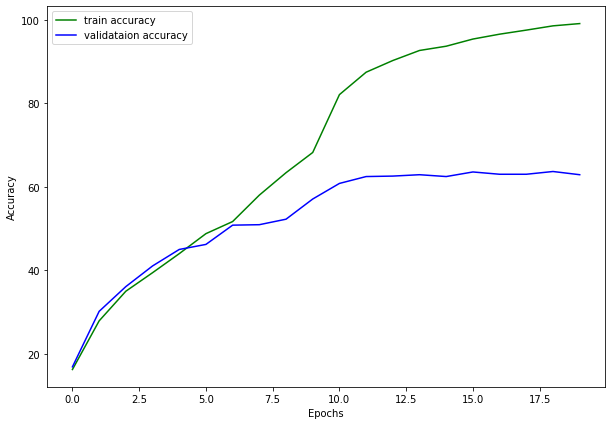

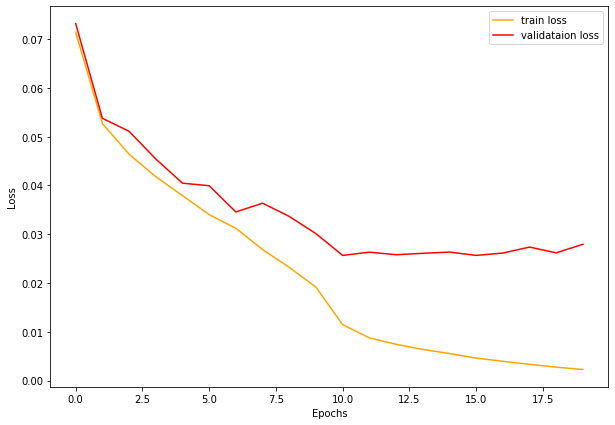

In [13]:
print(f"Training on {len(train_data)} examples, validating on {len(val_data)} examples...")
train_gated(model_gated, trainloader, valloader, decay=0)

In [14]:
correct, total = test(model, testloader)
print('Accuracy of testthe network on test images: %0.3f %%' % (100 * correct / total))
print('train.py finished running')

Accuracy of testthe network on test images: 74.070 %
train.py finished running
